In [1]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import numpy as np
import gc
import sys
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
sys.path.insert(0, '../')
from utils.utils import load_n_samples, AEDatagenerator

# Some major settings

In [3]:
training = True
use_dropout = True
model_std = False
mse_loss = True

In [4]:
name_dec = '../models/vae_dec.h5'
name_enc = '../models/vae_enc.h5'
name_vae = '../models/vae.h5'
additional = ''
if use_dropout:
    additional+='_dropout'
if model_std:
    additional+='_modeled_std'
if not additional:
    name_dec = '../models/vae_dec.h5'
    name_enc = '../models/vae_enc.h5'
    name_vae = '../models/vae.h5'
else:
    name_dec = '../models/vae_dec{0}.h5'.format(additional)
    name_enc = '../models/vae_enc{0}.h5'.format(additional)
    name_vae = '../models/vae{0}.h5'.format(additional)


# Loading data

In [5]:
abs_path = '../data/cropped/'
files = os.listdir(abs_path)
files = list(map(lambda x: os.path.join(abs_path, x), files))

In [6]:
train_path, test_path = train_test_split(files,test_size=0.15)

In [7]:
len(train_path), len(test_path)

(54032, 9536)

In [8]:
data = load_n_samples(abs_path=abs_path,samples=1000,workers=2)

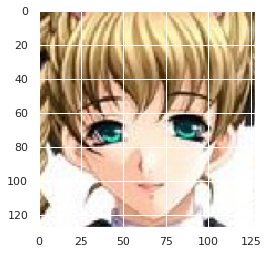

In [9]:
plt.imshow(data[0]);

# Training VAE

In [10]:
from math import pi

In [11]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [12]:
def build_model(original_dim, code_size, batch_size=32, x_std=0.1,var_epsilon=0.0001, kl_weight = 0.01,
                print_summary=True,use_dropout = False, model_std=False,mse_loss=False, weights_decoder=None, weights_encoder=None,
               weights_vae = False):
    K.clear_session()
    x = L.Input(batch_shape=(batch_size, *original_dim))
    encoder = create_encoder(original_dim,code_size,use_dropout)
    if weights_encoder:
        encoder.load_weights(weights_encoder)
    h = encoder(x)
    t_mean = L.Dense(code_size)(h)
    t_log_var = L.Dense(code_size)(h)
    t = L.Lambda(sample)([t_mean,t_log_var])
    decoder = create_decoder(code_size)
    if weights_decoder and not model_std:
        decoder.load_weights(weights_decoder)
    if model_std:
        decoder = tf.keras.Model(decoder.input, decoder.layers[-2].output)
        h1 = decoder(t)
        x_encoded_mean = L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = None, strides=2, padding='same')(h1)
        x_std =  L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = "relu", strides=2, padding='same')(h1)  
    if not model_std:
        x_encoded_mean = decoder(t)
    vae = tf.keras.Model(x,x_encoded_mean)
    if weights_vae:
        vae.load_weights(weights_vae)
        
    def kl_loss(x,x_encoded_mean):
        return -0.5* K.sum(1. + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=-1)
    
    def mse_loss(x,x_encoded_mean):
        return K.sum(K.square(x-x_encoded_mean),axis=-1)
    
    def logx_loss(x, x_encoded_mean):
        loss = 0.5*(K.log(2 * pi)
            +  K.log(x_std + var_epsilon)
            +  K.square(x - x_encoded_mean) / (x_std + var_epsilon))
        loss = K.sum(loss, axis=-1)
        return loss
    
    def vae_loss(x, x_encoded_mean):
        if mse_loss:
            
            return K.mean(mse_loss(x, x_encoded_mean) + kl_weight*kl_loss(x, x_encoded_mean))
        else:
            return K.mean(mse_loss(x, x_encoded_mean) + kl_weight*kl_loss(x, x_encoded_mean))
    
    vae.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=vae_loss)
    if print_summary:
        print(vae.summary())
    return vae,decoder, encoder


def sample(args):
    t_mean, t_log_var = args
    shape = tf.shape(t_mean)
    eps = tf.random.normal(
    shape=shape)
    return t_mean+eps*tf.exp(0.5*t_log_var)

def create_encoder(input_shape,code_size, use_dropout=False):
        encoder = tf.keras.models.Sequential(name='encoder')
        encoder.add(L.InputLayer(input_shape))
        if use_dropout:
            encoder.add(L.Dropout(0.2))
        encoder.add(L.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
        encoder.add(L.MaxPool2D())
        encoder.add(L.Flatten())
        encoder.add(L.Dense(units=code_size,activation='elu'))
        return encoder 

def create_decoder(code_size,use_dropout=True):
        decoder = tf.keras.models.Sequential(name='decoder')
        decoder.add(L.InputLayer((code_size,)))
        decoder.add(L.Dense(4096,activation='elu'))
        if use_dropout:
            decoder.add(L.Dropout(0.2))
        decoder.add(L.Dense(2*2*512,activation='elu'))
        decoder.add(L.Reshape(target_shape=(2,2,512)))
        decoder.add(L.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
        decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation = None, strides=2, padding='same'))
        return decoder


In [13]:
batch_size = 128
original_dim = (128,128,3)
code_size = 64
epochs = 100
std = 0.01
kl_weight = 1
var_epsilon = 0.001

In [ ]:
if training:
    vae,decoder, encoder = build_model(original_dim,code_size,batch_size,std,var_epsilon=var_epsilon,
                                   use_dropout=use_dropout,model_std=model_std,kl_weight=kl_weight,
                                      mse_loss=mse_loss)
    train_gen = AEDatagenerator(pathes=train_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2])
    test_gen = AEDatagenerator(pathes=test_path,batch_size=batch_size,
                            dim=original_dim[:2],
                            n_channels=original_dim[2])
    hist = vae.fit_generator(generator=train_gen,validation_data=test_gen,epochs=epochs,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])
    if not os.path.exists('../models'):
        os.mkdir('../models')
    encoder.save_weights(name_enc)
    decoder.save_weights(name_dec)
    vae.save_weights(name_vae)
else:
     vae,decoder, encoder = build_model(original_dim,code_size,batch_size,std,var_epsilon=var_epsilon,
                                   use_dropout=use_dropout,weights_encoder=name_enc,
                                       weights_decoder=name_dec,mse_loss=mse_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(128, 128, 128, 3)] 0                                            
__________________________________________________________________________________________________
encoder (Sequential)            multiple             1437056     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (128, 64)            4160        encoder[1][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (128, 64)            4160        encoder[1][0]                    
_____________

In [ ]:
model = tf.keras.Model(inputs=encoder.inputs, outputs=encoder.layers[-4].output)

In [ ]:
def visualize_layer():
    img = data[np.random.choice(data.shape[0])]
    feature_maps = model.predict(np.expand_dims(img,axis=0))
    square = 8
    ix = 1
    plt.figure(figsize=(15,12))
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='magma')
            ix += 1
    plt.show()

In [ ]:
visualize_layer()

# Having fun : )

## Generating random anime images

In [ ]:
if model_std:
    x = L.Input((code_size,))
    decoded = decoder(x)
    decoded = vae.layers[-1](decoded)
    generator = tf.keras.Model(x,decoded)
else:
    generator = decoder

## Reconstructing images

In [ ]:
idx1 = np.random.randint(0,len(data),size=128)
reconstruction = vae.predict(data[idx1])
print(np.mean(np.square(reconstruction-data[idx1])))
idx2 = np.random.randint(0,128,1)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(data[idx2][0])
ax2.imshow(reconstruction[idx2][0])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_title('Real one')
ax2.set_title('Reconstruction');

## Generating new images

In [ ]:
generated = generator.predict(np.random.normal(size=(1,code_size)))
plt.imshow(np.clip(generated[0],0,1))
plt.xticks([])
plt.yticks([])
plt.title('Generated images');

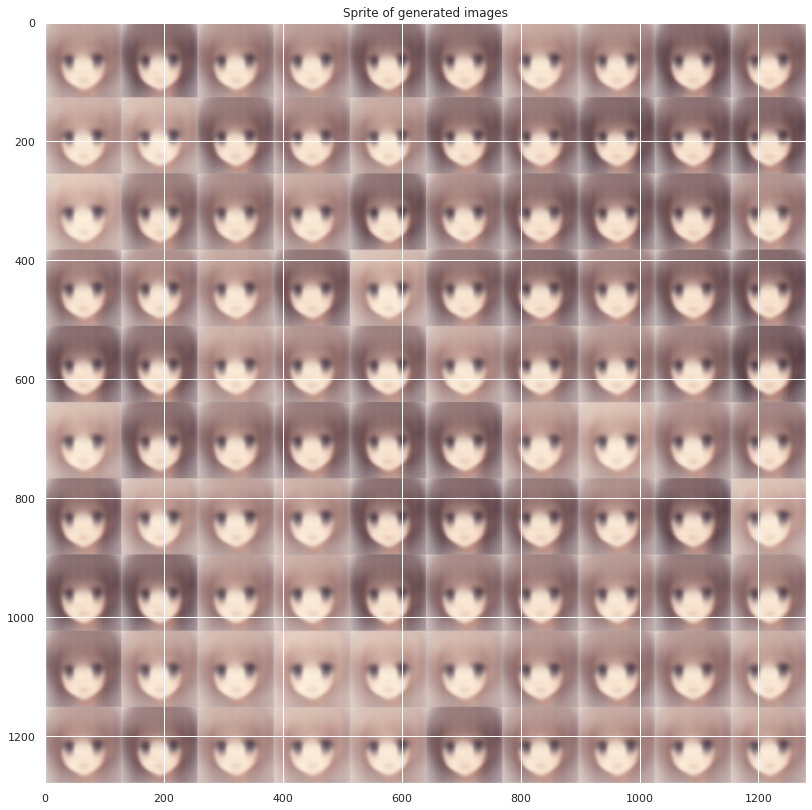

In [51]:
size = 128
n = 10  
figure = np.zeros((size * n, size * n,3))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=(1,code_size))
        x_decoded = generator.predict(z_sample)
        anime_face = x_decoded[0].reshape(size, size,3)
        
        x = i * size
        y = j * size
        figure[x:x + size, y:y + size] = anime_face

plt.figure(figsize=(14, 14))
plt.title('Sprite of generated images')
plt.imshow(figure)
plt.show()